In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
import re
from nltk.corpus import stopwords
from wordcloud import WordCloud
from nltk.stem import WordNetLemmatizer
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix,classification_report,accuracy_score

In [3]:
df =pd.read_csv('twitter_analysis.csv',encoding ='Latin-1',header =None)

In [4]:
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [5]:
df.columns =['Sentiment','Id','Date','Query','User','Text']

In [6]:
col =['Id','Date','Query','User']
df=df.drop(col,axis=1)

In [7]:
df.head()

,Sentiment,Text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1600000 entries, 0 to 1599999
Data columns (total 2 columns):
 #   Column     Non-Null Count    Dtype 
---  ------     --------------    ----- 
 0   Sentiment  1600000 non-null  int64 
 1   Text       1600000 non-null  object
dtypes: int64(1), object(1)
memory usage: 24.4+ MB


In [9]:
df.isnull().sum()

Sentiment    0
Text         0
dtype: int64

In [10]:
df.Sentiment.replace(4,1,inplace =True)

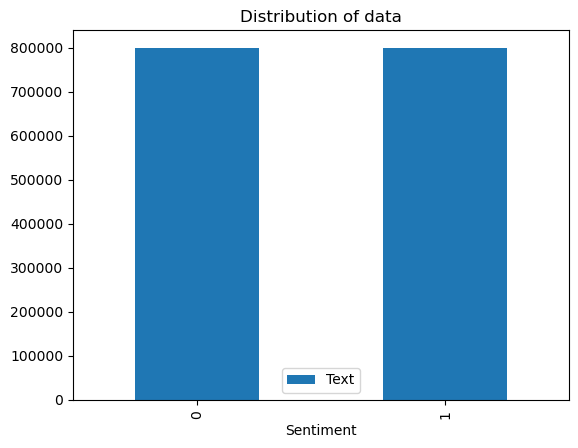

In [11]:
#Plotting the distribution of sentiment column
df.groupby('Sentiment').count().plot(kind='bar', title='Distribution of data')
plt.show()

### Text Preprocessing

In [12]:
stop_nltk = stopwords.words("english")
emoj = re.compile("["
        u"\U00002700-\U000027BF"  # Dingbats
        u"\U0001F600-\U0001F64F"  # Emoticons
        u"\U00002600-\U000026FF"  # Miscellaneous Symbols
        u"\U0001F300-\U0001F5FF"  # Miscellaneous Symbols And Pictographs
        u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        u"\U0001F680-\U0001F6FF"  # Transport and Map Symbols
                      "]+", re.UNICODE)

In [13]:
text = list(df['Text'])

In [14]:
sentiment =list(df['Sentiment'])

In [15]:
def processing(textdata):
    
    processedText =[]
    
    wordLemm =WordNetLemmatizer()
    
    urlPattern        =  r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    alphaPattern      = "[^a-zA-Z0-9]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        tweet = re.sub(emoj,' ',tweet)
        tweet = re.sub(urlPattern,'URL',tweet)
        tweet = re.sub(userPattern,'USER',tweet)
        tweet = re.sub(alphaPattern," ",tweet)
        tweet =re.sub(sequencePattern , seqReplacePattern,tweet)
        
        tweetwords =''
        
        for word in tweet.split():
            
            if word not in stop_nltk and len(word) > 1:
                word =wordLemm.lemmatize(word)
                tweetwords += (word+' ')
                
        processedText.append(tweetwords)
    return processedText

In [16]:
processedtext = processing(text)

### WordCloud for positive tweets

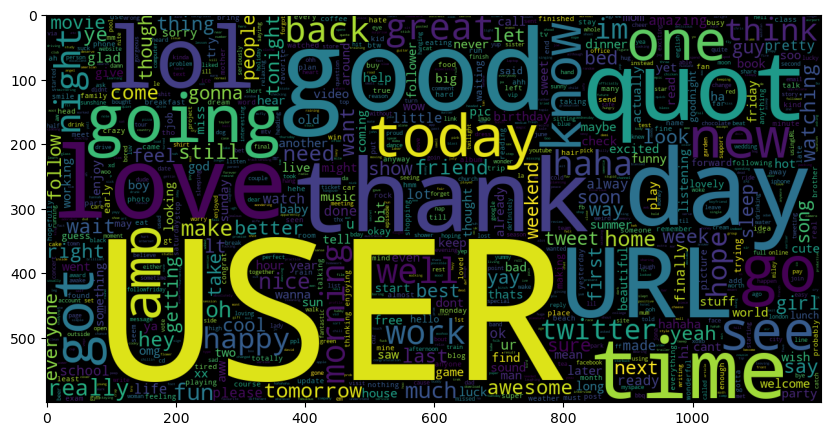

In [17]:
data_pos = processedtext[800000:]
wc = WordCloud(max_words = 1000 , width = 1200 , height = 600,collocations=False).generate(" ".join(data_pos))
plt.figure(figsize=(10,10))
plt.imshow(wc)

### WordCloud for negative tweets

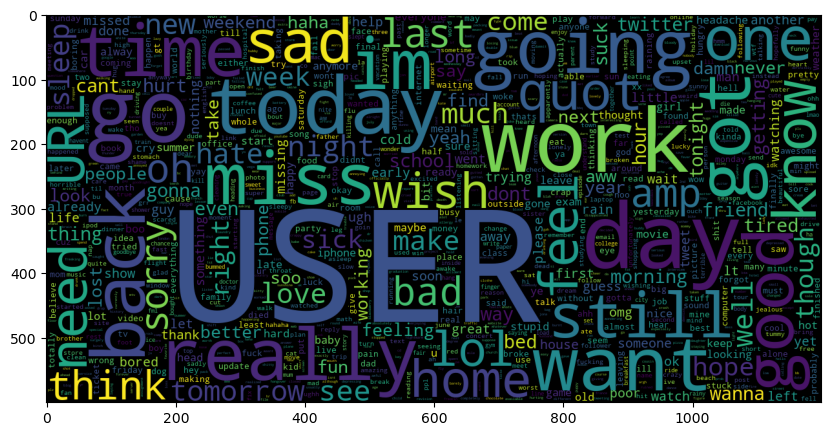

In [18]:
data_neg = processedtext[:800000]
wc1 = WordCloud(max_words = 1000 , width = 1200 , height = 600,collocations=False).generate(" ".join(data_neg))
plt.figure(figsize=(10,10))
plt.imshow(wc1)

### Splitting the data

In [19]:
X_train, X_test, y_train, y_test= train_test_split(processedtext,sentiment, test_size=0.05,random_state =42)

### Transforming the dataset

In [20]:
vectoriser = TfidfVectorizer(ngram_range=(1, 2),max_features=500000)
vectoriser.fit(X_train)
X_train =vectoriser.transform(X_train)
X_test =vectoriser.transform(X_test)

### Creating and Evaluating Models

In [21]:
def model_evaluate(model):
    
    y_pred = model.predict(X_test)
    cr_matrix = confusion_matrix(y_test,y_pred)
    print(classification_report(y_test,y_pred))
    
    categories =['Negative','Positive']
    group_names =['True Neg','False Pos','False Neg','True Pos']
    group_percentages =['{0:.2%}'.format(value) for value in cr_matrix.flatten()/np.sum(cr_matrix)]
    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    
    sns.heatmap(cr_matrix, annot = labels, cmap = 'Blues',fmt = '', xticklabels = categories, yticklabels = categories)
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Values')
    plt.ylabel('Actual Values')
    accuracy =accuracy_score(y_test,y_pred)
    print("Accuracy:",'{0:.2%}'.format(accuracy))

#### BernoulliNB Model

In [22]:
BNBmodel = BernoulliNB(alpha =2)
BNBmodel.fit(X_train,y_train)

BernoulliNB(alpha=2)

              precision    recall  f1-score   support

           0       0.79      0.77      0.78     39999
           1       0.78      0.80      0.79     40001

    accuracy                           0.78     80000
   macro avg       0.78      0.78      0.78     80000
weighted avg       0.78      0.78      0.78     80000

Accuracy: 78.34%


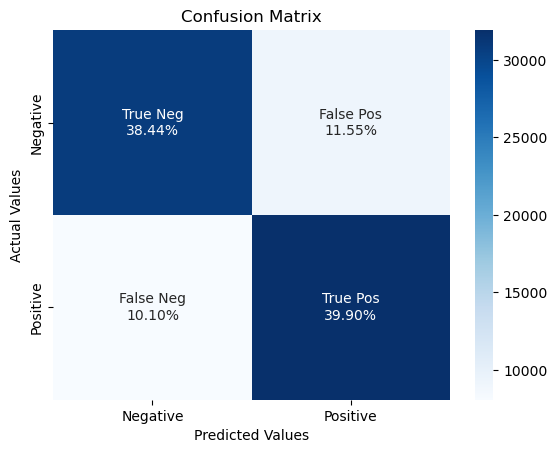

In [23]:
model_evaluate(BNBmodel)

#### LinearSVC Model

              precision    recall  f1-score   support

           0       0.79      0.76      0.78     39999
           1       0.77      0.80      0.78     40001

    accuracy                           0.78     80000
   macro avg       0.78      0.78      0.78     80000
weighted avg       0.78      0.78      0.78     80000

Accuracy: 78.05%


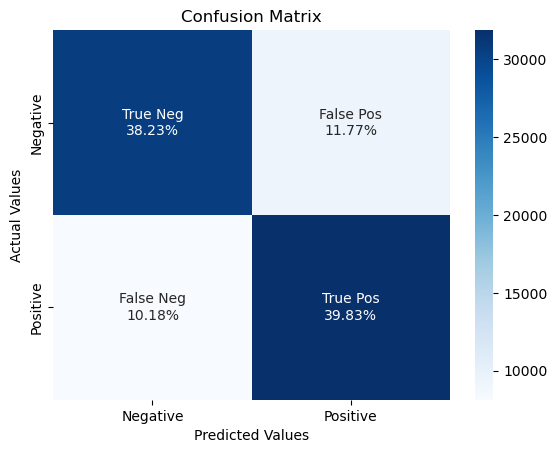

In [24]:
SVCmodel = LinearSVC()
SVCmodel.fit(X_train,y_train)
model_evaluate(SVCmodel)

#### Logistic Regression

              precision    recall  f1-score   support

           0       0.81      0.78      0.79     39999
           1       0.79      0.81      0.80     40001

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000

Accuracy: 79.62%


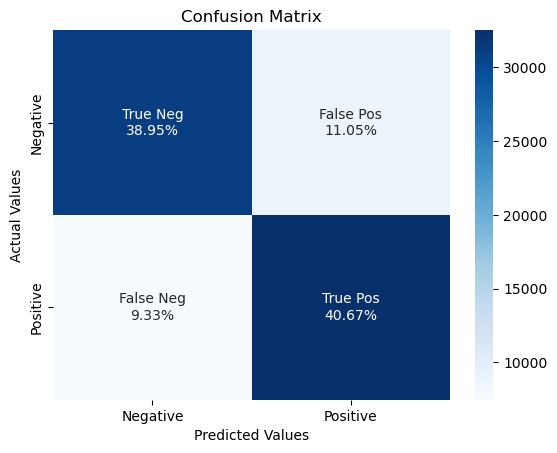

In [25]:
RegModel = LogisticRegression(max_iter=1000)
RegModel.fit(X_train,y_train)
model_evaluate(RegModel)